# XGBoost on GPU, no categories, with dates, including "onetimers"
## Predicting the time difference to the next repurchase

### Methods & Settings

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import gc
import joblib

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import XGBRegressor


from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

pd.set_option('display.max_rows', 250)
pd.set_option('display.max_columns', 50)

####
# prints memory usage
def show_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB\n'.format(start_mem))
    return

####
# seperates features from label (y must be last column)
def sep_X_y(df_train, df_test):
    X_train = df_train.iloc[:,0:-1] # extracts all rows [:] and columns from 0 to next-to-last [0:-1]
    y_train = df_train.iloc[:,-1] # extracts all rows [:] and only last column [-1]
    X_test = df_test.iloc[:,0:-1]
    y_test = df_test.iloc[:,-1]
    
    return [X_train, y_train, X_test, y_test]

####
# split training and test set from given dataframe with dates as boundaries
def dt_train_test_split(df, dt_start_train, dt_end_train, dt_start_test, dt_end_test):
    print('Splitting dataframe...\n')
    
    # get indices from desired boundaries
    idx_start_train = df.date.searchsorted(pd.to_datetime(dt_start_train), side='left') # list needs to be sorted already for searchsorted
    idx_end_train = df.date.searchsorted(pd.to_datetime(dt_end_train) + pd.Timedelta(days=1), side='left')
    idx_start_test = df.date.searchsorted(pd.to_datetime(dt_start_test), side='left')
    idx_end_test = df.date.searchsorted(pd.to_datetime(dt_end_test) + pd.Timedelta(days=1), side='left')
    
    train = df.iloc[idx_start_train:idx_end_train]
    test = df.iloc[idx_start_test:idx_end_test]
    
    train.drop(columns=['date'], axis=0, inplace=True)
    test.drop(columns=['date'], axis=0, inplace=True)
    
    return sep_X_y(train, test)

####
# trains XGB model (classifier)
def train_xgb(X, y):
    X_train = X
    y_train = y
    
    print('Fitting model...\n')
    model = XGBRegressor(tree_method='gpu_hist', gpu_id=0)
    fitted_model = model.fit(X_train, y_train)
    
    print('Plotting feature importance for "gain". Do not rely on that.\n')
    print('https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27\n')
    xgb.plot_importance(model, importance_type='gain')
    plt.show()
    
    # GRAPHVIZ (software + pip package) needed for tree plotting
    #fig, ax = plt.subplots(figsize=(30, 30))
    #xgb.plot_tree(model, num_trees=0, ax=ax, rankdir='LR')
    #plt.show()
    
    return fitted_model

def train_xgb_bestHyper(X, y):
    X_train = X
    y_train = y
    space = best_hyperparams
    
    print('Fitting model...\n')
    model = XGBRegressor(tree_method='gpu_hist', gpu_id=0,
                    eta = space['eta'],
                    max_depth = int(space['max_depth']), 
                    gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),
                    min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))

    
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    fitted_model.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)
    
    print('Plotting feature importance for "gain". Do not rely on that.\n')
    print('https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27\n')
    xgb.plot_importance(model, importance_type='gain')
    plt.show()
    
    # GRAPHVIZ (software + pip package) needed for tree plotting
    #fig, ax = plt.subplots(figsize=(30, 30))
    #xgb.plot_tree(model, num_trees=0, ax=ax, rankdir='LR')
    #plt.show()
    
    return fitted_model

def train_dtc(X, y):
    X_train = X
    y_train = y
    
    print('Fitting model...\n')
    model = DecisionTreeRegressor()
    fitted_model = model.fit(X_train, y_train)
    
    print('Plotting feature importance for "gain". Do not rely on that.\n')
    print('https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27\n')
    #xgb.plot_importance(model, importance_type='gain')
    #plt.show()
    
    # GRAPHVIZ (software + pip package) needed for tree plotting
    #fig, ax = plt.subplots(figsize=(30, 30))
    #xgb.plot_tree(model, num_trees=0, ax=ax, rankdir='LR')
    #plt.show()
    
    return fitted_model

####
# predicts labels of training and test with given model
def predict_values(model, X_train, y_train, X_test, y_test):
    print('Predicting values...\n')
    # predict y values
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    
    # get accuracies
    model_train = mean_squared_error(y_train, y_train_pred)
    model_test = mean_squared_error(y_test, y_test_pred)
    
    
    """
    #get precision
    model_train_precision = precision_score(y_train, y_train_pred, average)
    model_test_precision = precision_score(y_test, y_test_pred)
    """
    # print info about accuracies
    print(f'\n XGboost train/test rmse: '
         f'{model_train:.3f}/{model_test:.3f}')
    
    # return predicted values
    return [y_train_pred, y_test_pred]

def predict_values_train(model, X_train, y_train):
    print('Predicting values...\n')
    # predict y values
    y_train_pred = model.predict(X_train)

    # get accuracies
    model_train = mean_squared_error(y_train, y_train_pred)
    
    
    """
    #get precision
    model_train_precision = precision_score(y_train, y_train_pred, average)
    model_test_precision = precision_score(y_test, y_test_pred)
    """
    # print info about accuracies
    print(f'\n XGboost train'
         f'{model_train:.3f}')
    
    # return predicted values
    return y_train_pred

####
# concatenates prediction with actual target for evaluation
def evaluate_pred(X, y, y_pred):
    # create dataframe from test-prediction with index from X_test
    df_y_pred = pd.DataFrame(y_pred, columns=['nextBuyIn_pred'], index=X.index, dtype=np.int8)

    # concatenate X, y, y_pred (put columns next to each other)
    df_eval = pd.concat([X, y, df_y_pred], axis=1)
    
    return df_eval

####
# executes all needed functions of the above with given training and test data and provided train method
def execute_pipeline(train_method, df, list_of_four_df_boundaries):
    b = list_of_four_df_boundaries
    # split dataframe in train/test and X/y
    X_train, y_train, X_test, y_test = dt_train_test_split(df, b[0], b[1], b[2], b[3])
    
    #train model
    model = train_method(X_train, y_train)    
    
    # make predictions
    pred_train, pred_test = predict_values(model, X_train, y_train, X_test, y_test)
    
    print('\nExecuted pipeline.\nEvaluate with "evaluate_pred(X, y, y_pred)"\n')
    return [pred_train, pred_test, X_train, y_train, X_test, y_test]

In [2]:
file = r'E:\OneDrive\Arbeit\Repos\DMC2022\Kevin\csv\220623_complete_feature-list_orderhistory_trainingOhneNull.csv' # scores calculated with data from jun-oct

columns = [#'date',
           'userID', 
           'itemID',
           'order', 
           'brand', 
           'feature_1', 
           'feature_2', 
           'feature_3', 
           'feature_4', 
           'feature_5',
           'brandOrderRatio',
           'feature1OrderRatio',
           'feature2OrderRatio',
           'feature3OrderRatio',
           'feature4OrderRatio',
           'feature5OrderRatio',
           'TotalBFscore',
           'RCP',
           'MeanDiffToNxt(user)',
           'TotalItemOrders(user)',
           #'TotalItemOrders(item)',
           'date(year)',
           'date(month)',
           'date(weekOfMonth)',
           'date(dayOfMonth)',
           'date(weekOfYear)',
           'date(dayOfYear)',
           #'nextBuyInWeeks(round)', # label
           'nextBuyInWeeks(floor)', # label
           #'nextBuyInWeekOfYear' # label; schlechte idee
          ]

dtype = {'userID':np.uint16,
         'itemID':np.uint16,
         'order':np.uint8,
         'brand':np.int16,
         'feature_1':np.int8,
         'feature_2':np.uint8,
         'feature_3':np.int16,
         'feature_4':np.int8,
         'feature_5':np.int16}

---

# Predicting Weeks

## Preparation

In [3]:
df = pd.read_csv(file, usecols=columns, sep='|', dtype=dtype, nrows=None, converters={'date':pd.to_datetime})

show_mem_usage(df)
df.head()

Memory usage of dataframe is 24.55 MB



,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,brandOrderRatio,feature1OrderRatio,feature2OrderRatio,feature3OrderRatio,feature4OrderRatio,feature5OrderRatio,TotalBFscore,RCP,TotalItemOrders(user),MeanDiffToNxt(user),date(year),date(month),date(weekOfMonth),date(dayOfMonth),date(weekOfYear),date(dayOfYear),nextBuyInWeeks(floor)
0,76,23050,1,1411,4,0,22,0,151,0.007899,0.466804,0.826492,0.008540,0.640224,0.018705,0.940897,0.259374,2,169.0,2020,6,1,1,23,153,24
1,116,9408,1,322,4,0,536,0,144,0.012288,0.466804,0.826492,0.034208,0.640224,0.086085,0.988336,0.040000,3,114.5,2020,6,1,1,23,153,22
2,116,25677,1,322,4,0,536,0,144,0.012288,0.466804,0.826492,0.034208,0.640224,0.086085,0.988336,0.207143,3,114.5,2020,6,1,1,23,153,22
3,135,13660,1,157,4,0,513,0,137,0.010361,0.466804,0.826492,0.004528,0.640224,0.005142,0.933540,0.055556,2,32.0,2020,6,1,1,23,153,4
4,135,22174,1,504,10,0,441,3,84,0.005653,0.369146,0.826492,0.005184,0.334600,0.050564,0.757337,0.454545,3,40.5,2020,6,1,1,23,153,4


In [ ]:
column_headers = list(df.columns)
column_headers

## Training & Prediction

Pipeline needs training method, dataframe and dates to split dataframe in training and test set.

In [33]:
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor



X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

for model in [LogisticRegression, DecisionTreeClassifier, KNeighborsClassifier, RandomForestClassifier, GaussianNB, MLPClassifier, XGBClassifier]:
    cls = model()
    fitted_model = cls.fit(X_train, y_train)
    pred_train = cls.predict(X_train)
    pred_test = cls.predict(X_test)
    
    df_eval_train = evaluate_pred(X_train, y_train, pred_train)
    #df_eval_test = evaluate_pred(X_test, y_test, pred_test)

    #Eval
    mae=metrics.mean_absolute_error(y_train, y_pred_linReg)
    mse=metrics.mean_squared_error(y_train, y_pred_linReg)
    
    
    rowcount = len(df_eval_test)
    should = len(df_eval_test.loc[(df_eval_test.nextBuyInDays != 0)])
    is_ = len(df_eval_test.loc[(df_eval_test.nextBuyInDays != 0) & (df_eval_test.nextBuyInDays == df_eval_test.nextBuyIn_pred)]) 

    
    # Printing the metrics
    print(f'{model.__name__:22}')
    print('MAE: ', mae)
    print('MSE: ', mse)
    
    
    print(f'row count of set:\t\t\t\t\t {rowcount}')
    print(f'rows where label is not 0:\t\t\t\t {should} \t ({should/rowcount*100:.3f} % of all rows in set)')
    print(f'rows where label was predicted correctly AND not 0:\t {is_} \t ({is_/should*100:.3f} % of rows where label is not 0)')
    print()


In [ ]:
y_pred_rf = np.array([round(i) for i in y_pred_rf]) 

df_y_pred = pd.DataFrame(y_pred_rf, columns=['nextBuyIn_pred'], index=X_train.index)
# concatenate X, y, y_pred (put columns next to each other)
df_eval_train = pd.concat([X_train, y_train, df_y_pred], axis=1)
df_eval_train.head(200)

In [4]:
X_train = df.iloc[:,:-1]
y_train = df.iloc[:,-1]

#scaler_X = MinMaxScaler()
#scaler_y = MinMaxScaler()

#X_train_nrm = scaler_X.fit_transform(X_train)
#y_train_nrm = scaler_y.fit_transform(y_train)

#df_normalized = pd.DataFrame(df_normalized)
#df_normalized.set_axis(column_headers, axis=1,inplace=True)
#df_normalized
#X_train_nrm

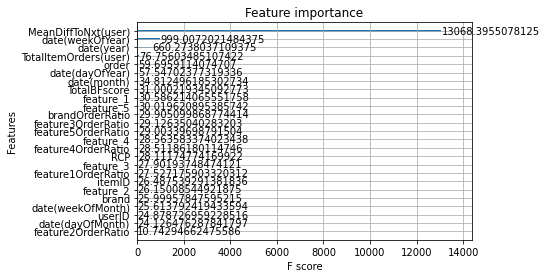

In [5]:
model = XGBRegressor(tree_method='gpu_hist', gpu_id=0)
fitted_model = model.fit(X_train, y_train)

xgb.plot_importance(model, importance_type='gain')
plt.show()

In [5]:
X_train = pd.DataFrame(X_train_nrm)
X_train.set_axis(column_headers[:-1], axis=1,inplace=True)
X_train

NameError: name 'X_train_nrm' is not defined

In [6]:
y_train_pred = model.predict(X_train)
y_train_pred = np.array([round(i) for i in y_train_pred]) 
y_train_pred = pd.Series(y_train_pred)
y_train_pred

0         24
1         20
2         20
3          4
4          5
          ..
171588     1
171589     2
171590     2
171591     1
171592     1
Length: 171593, dtype: int32

In [7]:
model_train = mean_squared_error(y_train, y_train_pred)

# print info about accuracies
print(f'\n XGboost train '
     f'{model_train:.3f}')


 XGboost train 4.861


In [19]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

#Prediction using test set 
y_pred_linReg = lin_reg.predict(X_train)

mae=metrics.mean_absolute_error(y_train, y_pred_linReg)
mse=metrics.mean_squared_error(y_train, y_pred_linReg)

# Printing the metrics
print('R2 square:',metrics.r2_score(y_train, y_train_pred))
print('MAE: ', mae)
print('MSE: ', mse)

R2 square: 0.889470931074882
MAE:  1.5179750158343353
MSE:  6.079054254316118


In [20]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

rf_regressor = RandomForestRegressor(n_estimators = 300 ,  random_state = 0)
rf_regressor.fit(X_train, y_train)

#Predicting the SalePrices using test set 
y_pred_rf = rf_regressor.predict(X_train)

mae=metrics.mean_absolute_error(y_train, y_pred_rf)
mse=metrics.mean_squared_error(y_train, y_pred_rf)

# Printing the metrics
print('Suppport Vector Regression Accuracy: ', rf_regressor.score(X_train, y_pred_rf))
print('R2 square:',metrics.r2_score(y_train, y_pred_rf))
print('MAE: ', mae)
print('MSE: ', mse)

Suppport Vector Regression Accuracy:  1.0
R2 square: 0.9814671251081621
MAE:  0.5135015220123587
MSE:  0.8150325311120564


In [22]:
y_pred_rf = np.array([round(i) for i in y_pred_rf]) 

df_y_pred = pd.DataFrame(y_pred_rf, columns=['nextBuyIn_pred'], index=X_train.index)
# concatenate X, y, y_pred (put columns next to each other)
df_eval_train = pd.concat([X_train, y_train, df_y_pred], axis=1)
df_eval_train.head(200)

,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,brandOrderRatio,feature1OrderRatio,feature2OrderRatio,feature3OrderRatio,feature4OrderRatio,feature5OrderRatio,TotalBFscore,RCP,TotalItemOrders(user),MeanDiffToNxt(user),date(year),date(month),date(weekOfMonth),date(dayOfMonth),date(weekOfYear),date(dayOfYear),nextBuyInWeeks(floor),nextBuyIn_pred
0,76,23050,1,1411,4,0,22,0,151,0.007899,0.466804,0.826492,0.008540,0.640224,0.018705,0.940897,0.259374,2,169.000000,2020,6,1,1,23,153,24,24
1,116,9408,1,322,4,0,536,0,144,0.012288,0.466804,0.826492,0.034208,0.640224,0.086085,0.988336,0.040000,3,114.500000,2020,6,1,1,23,153,22,21
2,116,25677,1,322,4,0,536,0,144,0.012288,0.466804,0.826492,0.034208,0.640224,0.086085,0.988336,0.207143,3,114.500000,2020,6,1,1,23,153,22,20
3,135,13660,1,157,4,0,513,0,137,0.010361,0.466804,0.826492,0.004528,0.640224,0.005142,0.933540,0.055556,2,32.000000,2020,6,1,1,23,153,4,4
4,135,22174,1,504,10,0,441,3,84,0.005653,0.369146,0.826492,0.005184,0.334600,0.050564,0.757337,0.454545,3,40.500000,2020,6,1,1,23,153,4,5
5,202,26940,1,1258,4,0,487,3,44,0.001213,0.466804,0.826492,0.024224,0.334600,0.059138,0.816166,0.123867,3,77.000000,2020,6,1,1,23,153,11,11
6,240,7318,1,1335,6,0,421,3,6,0.000549,0.152436,0.826492,0.021874,0.334600,0.002002,0.633827,0.279570,2,71.000000,2020,6,1,1,23,153,10,10
7,240,26645,1,648,10,0,358,3,24,0.001713,0.369146,0.826492,0.009509,0.334600,0.004315,0.735008,0.106439,2,71.000000,2020,6,1,1,23,153,10,10
8,244,10341,1,1025,6,0,198,0,17,0.002099,0.152436,0.826492,0.000869,0.640224,0.078879,0.810581,0.228986,3,109.000000,2020,6,1,1,23,153,15,15
9,276,15667,1,1201,4,0,30,0,163,0.012826,0.466804,0.826492,0.001585,0.640224,0.017563,0.939354,0.138325,8,51.750000,2020,6,1,1,23,153,8,7


In [23]:
rowcount = len(df_eval_train)
should = rowcount
is_ = len(df_eval_train.loc[(df_eval_train['nextBuyInWeeks(floor)'] == df_eval_train.nextBuyIn_pred)]) 

print(f'row count of set:\t\t\t\t {rowcount}')
print(f'rows where label was predicted correctly:\t {is_} \t ({is_/should*100:.3f} % of rows)')

row count of set:				 171593
rows where label was predicted correctly:	 114071 	 (66.478 % of rows)


# Bayesian Regression

In [ ]:
reg = linear_model.BayesianRidge()

In [27]:
from sklearn import linear_model

bayesian = linear_model.BayesianRidge()
bayesian.fit(X_train, y_train)

#Predicting the SalePrices using test set 
y_pred_bay = bayesian.predict(X_train)

mae=metrics.mean_absolute_error(y_train, y_pred_bay)
mse=metrics.mean_squared_error(y_train, y_pred_bay)

# Printing the metrics
print('R2 square:',metrics.r2_score(y_train, y_pred_bay))
print('MAE: ', mae)
print('MSE: ', mse)

R2 square: 0.8617675796441506
MAE:  1.5175658837272468
MSE:  6.079138833122573


In [30]:
y_pred_bay = np.array([round(i) for i in y_pred_bay]) 

df_y_pred = pd.DataFrame(y_pred_bay, columns=['nextBuyIn_pred'], index=X_train.index)
# concatenate X, y, y_pred (put columns next to each other)
df_eval_train = pd.concat([X_train, y_train, df_y_pred], axis=1)
df_eval_train.head(200)

,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,brandOrderRatio,feature1OrderRatio,feature2OrderRatio,feature3OrderRatio,feature4OrderRatio,feature5OrderRatio,TotalBFscore,RCP,TotalItemOrders(user),MeanDiffToNxt(user),date(year),date(month),date(weekOfMonth),date(dayOfMonth),date(weekOfYear),date(dayOfYear),nextBuyInWeeks(floor),nextBuyIn_pred
0,76,23050,1,1411,4,0,22,0,151,0.007899,0.466804,0.826492,0.008540,0.640224,0.018705,0.940897,0.259374,2,169.000000,2020,6,1,1,23,153,24,24
1,116,9408,1,322,4,0,536,0,144,0.012288,0.466804,0.826492,0.034208,0.640224,0.086085,0.988336,0.040000,3,114.500000,2020,6,1,1,23,153,22,16
2,116,25677,1,322,4,0,536,0,144,0.012288,0.466804,0.826492,0.034208,0.640224,0.086085,0.988336,0.207143,3,114.500000,2020,6,1,1,23,153,22,16
3,135,13660,1,157,4,0,513,0,137,0.010361,0.466804,0.826492,0.004528,0.640224,0.005142,0.933540,0.055556,2,32.000000,2020,6,1,1,23,153,4,5
4,135,22174,1,504,10,0,441,3,84,0.005653,0.369146,0.826492,0.005184,0.334600,0.050564,0.757337,0.454545,3,40.500000,2020,6,1,1,23,153,4,6
5,202,26940,1,1258,4,0,487,3,44,0.001213,0.466804,0.826492,0.024224,0.334600,0.059138,0.816166,0.123867,3,77.000000,2020,6,1,1,23,153,11,11
6,240,7318,1,1335,6,0,421,3,6,0.000549,0.152436,0.826492,0.021874,0.334600,0.002002,0.633827,0.279570,2,71.000000,2020,6,1,1,23,153,10,10
7,240,26645,1,648,10,0,358,3,24,0.001713,0.369146,0.826492,0.009509,0.334600,0.004315,0.735008,0.106439,2,71.000000,2020,6,1,1,23,153,10,10
8,244,10341,1,1025,6,0,198,0,17,0.002099,0.152436,0.826492,0.000869,0.640224,0.078879,0.810581,0.228986,3,109.000000,2020,6,1,1,23,153,15,16
9,276,15667,1,1201,4,0,30,0,163,0.012826,0.466804,0.826492,0.001585,0.640224,0.017563,0.939354,0.138325,8,51.750000,2020,6,1,1,23,153,8,8


In [31]:
rowcount = len(df_eval_train)
should = rowcount
is_ = len(df_eval_train.loc[(df_eval_train['nextBuyInWeeks(floor)'] == df_eval_train.nextBuyIn_pred)]) 

print(f'row count of set:\t\t\t\t {rowcount}')
print(f'rows where label was predicted correctly:\t {is_} \t ({is_/should*100:.3f} % of rows)')

row count of set:				 171593
rows where label was predicted correctly:	 69419 	 (40.456 % of rows)


In [11]:
!pip install seaborn

<AxesSubplot:>

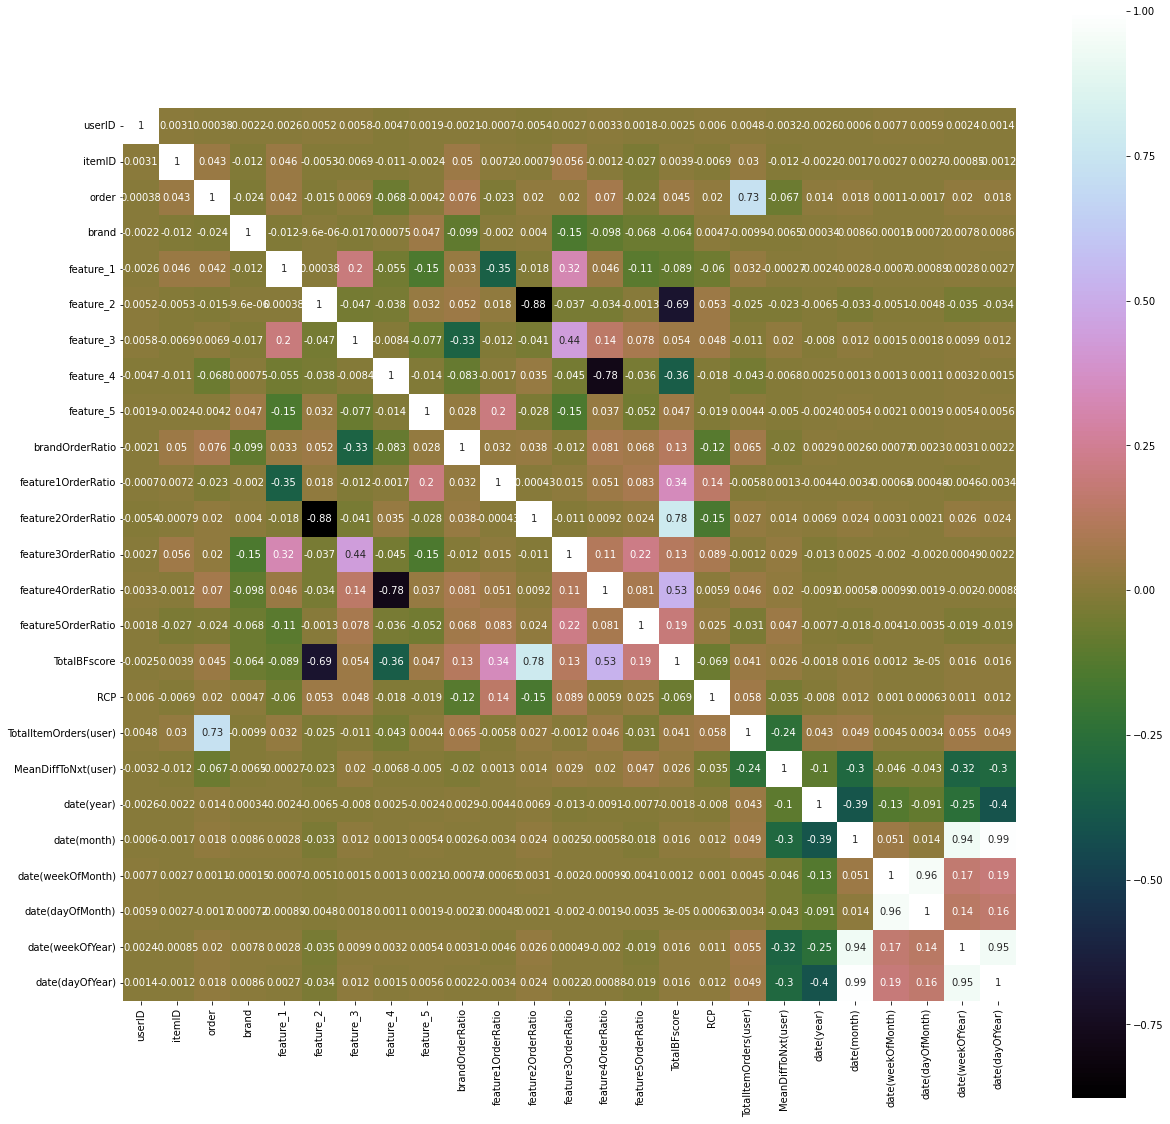

In [15]:
import seaborn as sns
corr_mat = X_train.corr(method='pearson')
plt.figure(figsize=(20,20))
sns.heatmap(corr_mat,vmax=1,square=True,annot=True,cmap='cubehelix')

In [34]:
df_y_pred = pd.DataFrame(y_train_pred, columns=['nextBuyIn_pred'], index=X_train.index)
# concatenate X, y, y_pred (put columns next to each other)
df_eval_train = pd.concat([X_train, y_train, df_y_pred], axis=1)
df_eval_train.head(200)

,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,brandOrderRatio,feature1OrderRatio,feature2OrderRatio,feature3OrderRatio,feature4OrderRatio,feature5OrderRatio,TotalBFscore,RCP,TotalItemOrders(user),MeanDiffToNxt(user),date(year),date(month),date(weekOfMonth),date(dayOfMonth),date(weekOfYear),date(dayOfYear),nextBuyInWeeks(floor),nextBuyIn_pred
0,76,23050,1,1411,4,0,22,0,151,0.007899,0.466804,0.826492,0.008540,0.640224,0.018705,0.940897,0.259374,2,169.000000,2020,6,1,1,23,153,24,24
1,116,9408,1,322,4,0,536,0,144,0.012288,0.466804,0.826492,0.034208,0.640224,0.086085,0.988336,0.040000,3,114.500000,2020,6,1,1,23,153,22,20
2,116,25677,1,322,4,0,536,0,144,0.012288,0.466804,0.826492,0.034208,0.640224,0.086085,0.988336,0.207143,3,114.500000,2020,6,1,1,23,153,22,20
3,135,13660,1,157,4,0,513,0,137,0.010361,0.466804,0.826492,0.004528,0.640224,0.005142,0.933540,0.055556,2,32.000000,2020,6,1,1,23,153,4,4
4,135,22174,1,504,10,0,441,3,84,0.005653,0.369146,0.826492,0.005184,0.334600,0.050564,0.757337,0.454545,3,40.500000,2020,6,1,1,23,153,4,5
5,202,26940,1,1258,4,0,487,3,44,0.001213,0.466804,0.826492,0.024224,0.334600,0.059138,0.816166,0.123867,3,77.000000,2020,6,1,1,23,153,11,11
6,240,7318,1,1335,6,0,421,3,6,0.000549,0.152436,0.826492,0.021874,0.334600,0.002002,0.633827,0.279570,2,71.000000,2020,6,1,1,23,153,10,10
7,240,26645,1,648,10,0,358,3,24,0.001713,0.369146,0.826492,0.009509,0.334600,0.004315,0.735008,0.106439,2,71.000000,2020,6,1,1,23,153,10,10
8,244,10341,1,1025,6,0,198,0,17,0.002099,0.152436,0.826492,0.000869,0.640224,0.078879,0.810581,0.228986,3,109.000000,2020,6,1,1,23,153,15,16
9,276,15667,1,1201,4,0,30,0,163,0.012826,0.466804,0.826492,0.001585,0.640224,0.017563,0.939354,0.138325,8,51.750000,2020,6,1,1,23,153,8,7


## XGBoost

### Evaluation

In [35]:
rowcount = len(df_eval_train)
should = len(df_eval_train.loc[(df_eval_train['nextBuyInWeeks(floor)'] != 0)])
is_ = len(df_eval_train.loc[(df_eval_train['nextBuyInWeeks(floor)'] != 0) & (df_eval_train['nextBuyInWeeks(floor)'] == df_eval_train.nextBuyIn_pred)]) 

print(f'row count of set:\t\t\t\t\t {rowcount}')
print(f'rows where label is not 0:\t\t\t\t {should} \t ({should/rowcount*100:.3f} % of all rows in set)')
print(f'rows where label was predicted correctly AND not 0:\t {is_} \t ({is_/should*100:.3f} % of rows where label is not 0)')

row count of set:					 171593
rows where label is not 0:				 171593 	 (100.000 % of all rows in set)
rows where label was predicted correctly AND not 0:	 80610 	 (46.977 % of rows where label is not 0)


In [36]:
rowcount = len(df_eval_train)
should = rowcount
is_ = len(df_eval_train.loc[(df_eval_train['nextBuyInWeeks(floor)'] == df_eval_train.nextBuyIn_pred)]) 

print(f'row count of set:\t\t\t\t {rowcount}')
print(f'rows where label was predicted correctly:\t {is_} \t ({is_/should*100:.3f} % of rows)')

row count of set:				 171593
rows where label was predicted correctly:	 80610 	 (46.977 % of rows)


---

## Decision Tree

In [ ]:
%%time
#dtc
pred_train, pred_test, X_train, y_train, X_test, y_test = execute_pipeline(train_dtc, df, [
    '2020-06-01', # start train set
    '2020-10-31', # end train set
    '2020-11-01', # start test set
    '2020-11-30'  # end test set
])

### Evaluation

#### train set

In [ ]:
df_eval_train = evaluate_pred(X_train, y_train, pred_train)

#### test set

In [ ]:
df_eval_test = evaluate_pred(X_test, y_test, pred_test)

In [ ]:
rowcount = len(df_eval_test)
should = len(df_eval_test.loc[(df_eval_test.nextBuyInWeeks != 0)])
is_ = len(df_eval_test.loc[(df_eval_test.nextBuyInWeeks != 0) & (df_eval_test.nextBuyInWeeks == df_eval_test.nextBuyIn_pred)]) 

print(f'row count of set:\t\t\t\t\t {rowcount}')
print(f'rows where label is not 0:\t\t\t\t {should} \t ({should/rowcount*100:.3f} % of all rows in set)')
print(f'rows where label was predicted correctly AND not 0:\t {is_} \t ({is_/should*100:.3f} % of rows where label is actually 0)')

## Hyperparameter Tuning

In [ ]:
!pip install hyperopt

In [ ]:
import hyperopt
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space = {
        'eta': hp.quniform('eta', 0.01, 0.5, 0.01),
        'max_depth': hp.quniform('max_depth', 3, 5, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40, 180, 1),
        'reg_lambda' : hp.uniform('reg_lambda', 0, 1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 1000,
        'seed': 0
    }

In [ ]:
def objective(space):
    reg=xgb.XGBRegressor(tree_method='gpu_hist', gpu_id=0,
                    eta = space['eta'],
                    max_depth = int(space['max_depth']), 
                    gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),
                    min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']),
                    n_estimators = space['n_estimators'])
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    reg.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)
    

    pred = reg.predict(X_test)
    loss = mean_squared_error(y_test, pred)
    print ("LOSS:", loss)
    return {'loss': loss, 'status': STATUS_OK }

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 1000,
                        trials = trials)

In [ ]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

In [ ]:
type(best_hyperparams)

## XGBoost mit optimierten Hyperparametern

In [ ]:
%%time
pred_train, pred_test, X_train, y_train, X_test, y_test = execute_pipeline(train_xgb_bestHyper, df, [
    '2020-06-01', # start train set
    '2020-10-31', # end train set
    '2020-11-01', # start test set
    '2020-11-30'  # end test set
])

### Evaluation

#### train set

In [ ]:
df_eval_train = evaluate_pred(X_train, y_train, pred_train)

#### test set

In [ ]:
df_eval_test = evaluate_pred(X_test, y_test, pred_test)

In [ ]:
rowcount = len(df_eval_test)
should = len(df_eval_test.loc[(df_eval_test.nextBuyInWeeks != 0)])
is_ = len(df_eval_test.loc[(df_eval_test.nextBuyInWeeks != 0) & (df_eval_test.nextBuyInWeeks == df_eval_test.nextBuyIn_pred)]) 

print(f'row count of set:\t\t\t\t\t {rowcount}')
print(f'rows where label is not 0:\t\t\t\t {should} \t ({should/rowcount*100:.3f} % of all rows in set)')
print(f'rows where label was predicted correctly AND not 0:\t {is_} \t ({is_/should*100:.3f} % of rows where label is actually 0)')